### Importing libraries

In [296]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

### Configuring hardware

In [297]:
physical_devices = tf.config.list_physical_devices()

print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [298]:
tf.config.set_visible_devices(physical_devices[1], 'GPU')

### Loading data

##### Processed dataset with pre-selecter features (by Random Forest)

In [299]:
# data_train = pd.read_csv('data/processed/train_meaningfull.csv')
# data_test = pd.read_csv('data/processed/test_meaningfull.csv')

##### Raw dataset with (>500 features)

In [300]:
data_train = pd.read_csv('data/raw/train.csv')
data_test = pd.read_csv('data/raw/test.csv')

##### Processing data

In [301]:
X_train = data_train.drop('Activity', axis='columns')
y_train = data_train['Activity']
y_train_encoded = pd.get_dummies(y_train)

In [302]:
X_test = data_test.drop('Activity', axis='columns')
y_test = data_test['Activity']
y_test_encoded = pd.get_dummies(y_test)

### Build model

In [303]:
from tensorflow import keras
from keras import regularizers
from keras import layers

regularizer = regularizers.l2(l=0.01)

model = keras.Sequential(
  [
    layers.Input(X_train.shape[-1]),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizer),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu", kernel_regularizer=regularizer),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizer),
    layers.Dropout(0.4),
    layers.Dense(6, activation="sigmoid"),
  ]
)
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 128)               72064     
                                                                 
 dropout_57 (Dropout)        (None, 128)               0         
                                                                 
 dense_77 (Dense)            (None, 256)               33024     
                                                                 
 dropout_58 (Dropout)        (None, 256)               0         
                                                                 
 dense_78 (Dense)            (None, 128)               32896     
                                                                 
 dropout_59 (Dropout)        (None, 128)               0         
                                                                 
 dense_79 (Dense)            (None, 6)               

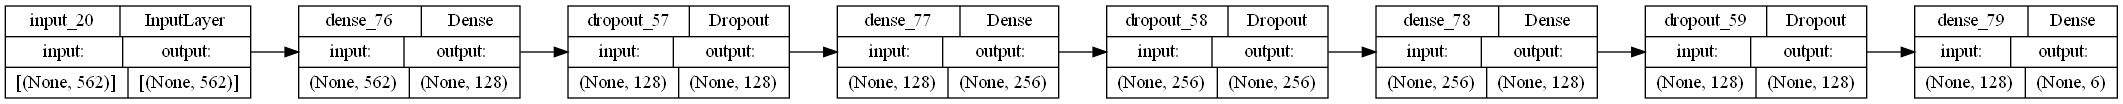

In [304]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [305]:
optimizer = keras.optimizers.Adadelta(learning_rate=1e-1, rho=0.95, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics='accuracy')

In [306]:
history = model.fit(
  X_train,
  y_train_encoded,
  batch_size=1000,
  epochs=1000,
  verbose=1,
  validation_split=0.3
)

Epoch 1/1000
6/6 [==============================] - 1s 64ms/step - loss: 7.4710 - accuracy: 0.1840 - val_loss: 7.3225 - val_accuracy: 0.1505
Epoch 2/1000
6/6 [==============================] - 0s 23ms/step - loss: 7.3874 - accuracy: 0.1998 - val_loss: 7.2600 - val_accuracy: 0.1800
Epoch 3/1000
6/6 [==============================] - 0s 24ms/step - loss: 7.3270 - accuracy: 0.2103 - val_loss: 7.1944 - val_accuracy: 0.1840
Epoch 4/1000
6/6 [==============================] - 0s 24ms/step - loss: 7.2544 - accuracy: 0.2227 - val_loss: 7.1337 - val_accuracy: 0.1922
Epoch 5/1000
6/6 [==============================] - 0s 18ms/step - loss: 7.1873 - accuracy: 0.2443 - val_loss: 7.0796 - val_accuracy: 0.1931
Epoch 6/1000
6/6 [==============================] - 0s 13ms/step - loss: 7.1300 - accuracy: 0.2522 - val_loss: 7.0229 - val_accuracy: 0.1877
Epoch 7/1000
6/6 [==============================] - 0s 14ms/step - loss: 7.0712 - accuracy: 0.2616 - val_loss: 6.9629 - val_accuracy: 0.1945
Epoch 8/1000


In [307]:
score = model.evaluate(X_test, y_test_encoded)[1]

print(score)

93/93 [==============================] - 0s 3ms/step - loss: 0.5512 - accuracy: 0.9131
0.9131320118904114


Text(0.5, 1.0, 'Accuracy Curves')

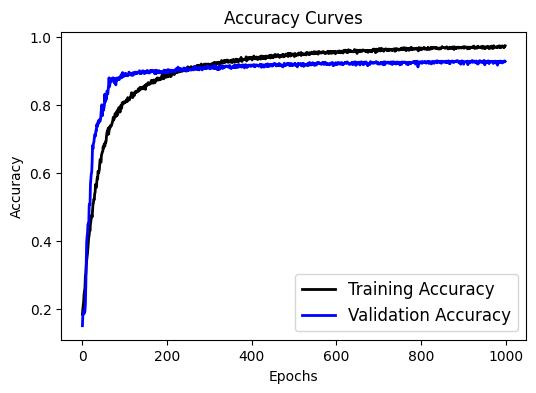

In [309]:
# Plotting the accuracy curve
plt.figure(figsize=[6, 4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)